# Setup

Running the simulations presumes the installation of specific packages, in particular Gammapy0.19. The easiest is maybe to simply recreate my conda environment, and run this notebook from there. Download the file env_swyft3-ext.yaml, and write the following in the terminal:

```
$conda env create --file env_swyft3-ext.yaml --name swyft3
$conda activate swyft3
```
Then download the IRF file *Prod5-North-20deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits* and *ALP_quick_sim.py*. If you place them in the same directory as this notebook, you should be set to run. Otherwise adapt the paths in the following cell:


In [1]:
import os
ALP_file_dir = os.path.dirname(os.getcwd())+"/analysis_scripts/ALP_sim"             # The directory where ALP_quick_sim.py is placed. Can be empty if it's in same folder as notebook. 

In [2]:
import sys
if ALP_file_dir: sys.path.append(ALP_file_dir)   #!!! Change path to location of differential_counts.py and ALP_sim.py
from ALP_quick_sim import ALP_sim

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
# import swyft.lightning as sl
import swyft

In [6]:
import torch
import torch.distributions as td

In [7]:
import scipy.stats as scist

In [8]:
from joblib import Parallel, delayed

In [9]:
import copy

In [10]:
A = ALP_sim(set_obs=False,set_null=False)

# Configuration

In [11]:
A.configure_model(
    model="toy_poly",
    noise="gauss",
    sigma=0.2,
    param_names = ['m','g','A'],
    floor=None
)

In [12]:
A._geom_type

'gamma'

In [13]:
A.configure_obs(
    nbins = 100,
    emin = -1,
    emax = 1,
    geom = "simple"
)

yoop


In [14]:
n_sim = 10_000

bounds = [
    [-1,1],
    [-1,1],
    [-1,1]
]

truth = [0.09762701, 0.43037873, 0.20552675]


# Simulation setup

In [15]:
class ALP_SWYFT_Simulator(swyft.Simulator):
    def __init__(self, A, bounds=None):
        super().__init__()

        self.transform_samples = swyft.to_numpy32
        
        self.A = copy.deepcopy(A)
        self.bounds = bounds

        self.samplers = []
        for i,bound in enumerate(bounds):
            self.samplers.append(scist.uniform(loc=bound[0], scale=bound[1]-bound[0]))
            
        
    def sample_prior(self,):
        param_sample = [sampler.rvs() for sampler in self.samplers]
        return np.array(param_sample)

    def generate_exp(self,vec):
        exp = A.simulate(vec)['y']
        return exp

    def generate_data(self,exp,params):
        data = A.noise({'y':exp},params)['y']
        return data

    def build(self, graph):
        params = graph.node('params', self.sample_prior)
        exp = graph.node('exp', self.generate_exp, params)
        data = graph.node('data', self.generate_data,exp,params)
        

In [16]:
sim = ALP_SWYFT_Simulator(A, bounds)

In [17]:
samples = sim.sample(n_sim, targets=['data','exp','params'])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
obs_exp=sim.generate_exp(truth)
obs_data = sim.generate_data(obs_exp,truth)
obs = swyft.Sample(data=obs_data, exp=obs_exp, params=truth)

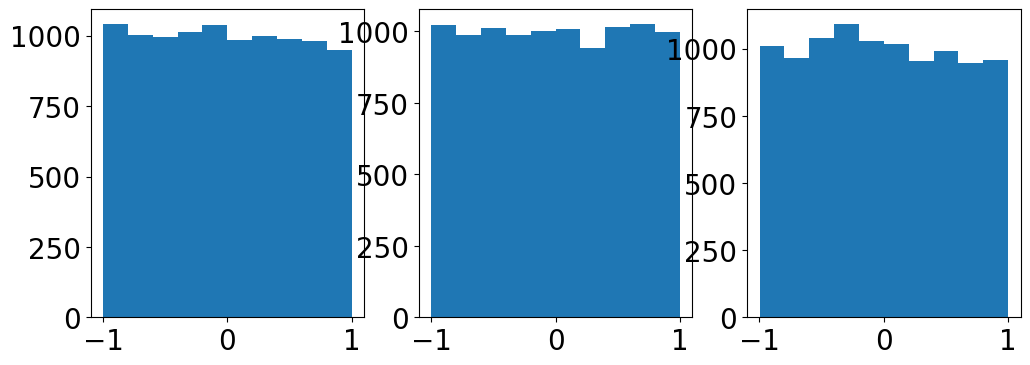

In [19]:
plt.figure(figsize=(12,4))
for i in range(len(bounds)):
    plt.subplot(1,3,i+1)
    plt.hist(samples['params'][:,i])

In [20]:
colors = ['r','#FFA500','y','g','c','b','m']
A.configure_plot(xmin=None, xmax=None, legend=0, logx=0, logy=0)
for i in range(min(len(samples),7)):
    A.configure_model(params=samples[i]['params'])
    A.import_counts(obs=samples[i]['data'],exp=samples[i]['exp'])
    new_fig = 1 if i==0 else 0
    A.compute_case(new_fig=new_fig,new_counts=0,color=colors[i],color_obs=colors[i],linestyle="-",
                   label_obs=False, errorbands=False)
A.configure_model(params=obs['params'])
A.import_counts(obs=obs['data'],exp=obs['exp'])
A.compute_case(new_fig=0,new_counts=0,color='k',color_obs='k',linestyle="-",label_obs=0,errorbands=0)  

/home/gert/ALPs_with_SWYFT/analysis_scripts/ALP_sim/ALP_quick_sim.py:355: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if params != "_empty" and not np.array_equiv(np.array(params),np.array(self.params)):
/home/gert/ALPs_with_SWYFT/analysis_scripts/ALP_sim/ALP_quick_sim.py:472: UserWarning: Imported observed counts should all be integers
  warnings.warn("Imported observed counts should all be integers")


UnboundLocalError: local variable 'lower_error' referenced before assignment

In [21]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features = A.nbins, 
            num_params = len(bounds), 
            varnames = sim.A.param_names)
        self.learning_rate = 0.0005
    
    def forward(self, A, B):
        return self.logratios(A['data'], B['params'])

In [22]:
network = Network()

In [23]:
trainer = swyft.SwyftTrainer(
    accelerator = 'cpu', precision = 64 #, min_epochs =25, 
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [24]:
dm = swyft.SwyftDataModule(samples)

In [25]:
trainer.fit(network, dm)

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 71.2 K
-----------------------------------------------------
71.2 K    Trainable params
0         Non-trainable params
71.2 K    Total params
0.570     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /home/gert/ALPs_with_SWYFT/notebooks/lightning_logs/version_8/checkpoints/epoch=0-step=250.ckpt


In [26]:
prior_samples = sim.sample(100_000, targets=['params'])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [27]:
logratios = trainer.infer(
                        network,
                        obs,
                        prior_samples
                        )

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


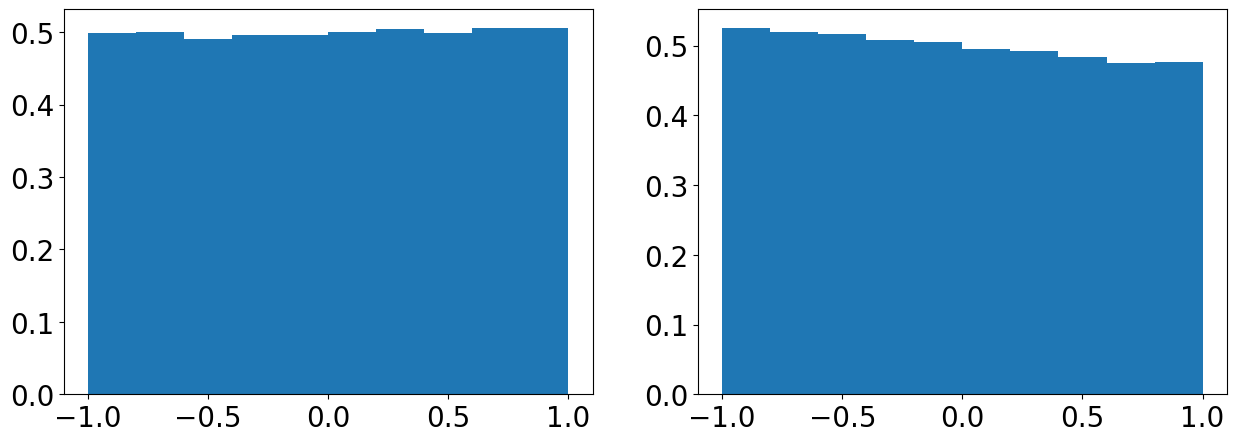

In [28]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for i in range(2):
    axs[i].hist(
        logratios.params[:,i,0],
        density=True,
        weights=np.exp(logratios.logratios[:,i])
    )

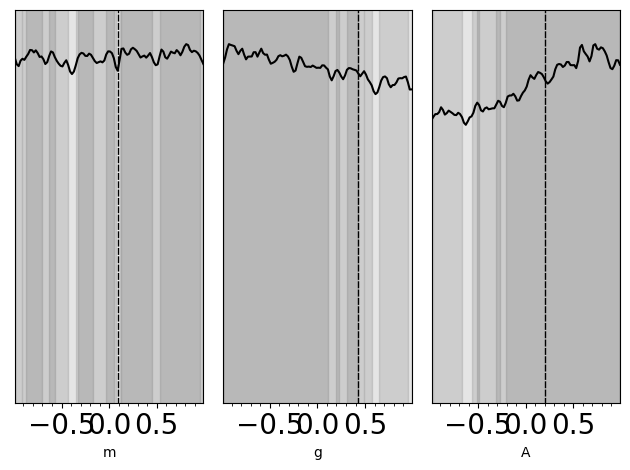

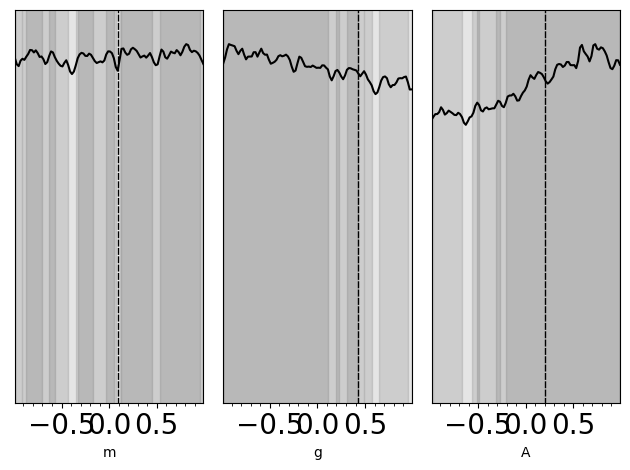

In [29]:
swyft.plot_posterior(logratios, A.param_names, truth={A.param_names[i]:truth[i] for i in range(len(truth))})

In [30]:
truth

[0.09762701, 0.43037873, 0.20552675]